# PHRINGE x NIFITS Example
This example let's you quickly create basic NIFITS files containing synthetic nulling data of exoplanetary systems generated with **PHRINGE**. 

The full documentation of **PHRINGE** with instructions and examples can be found __[here](https://phringe.readthedocs.io/en/latest/index.html)__.
Note that the integration of NIFITS into PHRINGE is minimal at the moment and will be extended in the future. 

The main prerequisites for this notebook are:
- Python **3.10 or 3.11** (< 3.10 and > 3.11 is currently not supported due to complicated dependencies)
- Installation of **PHRINGE** (run `pip install phringe` in your terminal)
- Installation of **nifits**

### PHRINGE Configuration
This basic configuration setup corresponds to an observation of an Earth-like planet around a Sun-like star at 10pc made with LIFE. Feel free to adapt the parameters to your liking.

In [1]:
from sympy import Matrix, sin, exp, pi, I, cos, symbols, sqrt

########################################################################################################################
# Array Configuration Matrix (2 x N_in)
########################################################################################################################

t, tm, b = symbols('t tm b')  # Do not change this (t: time, tm: modulation period, b: baseline)

q = 6
acm = (b / 2
       * Matrix([[cos(2 * pi / tm * t), -sin(2 * pi / tm * t)],
                 [sin(2 * pi / tm * t), cos(2 * pi / tm * t)]])
       * Matrix([[q, q, -q, -q],
                 [1, -1, -1, 1]]))

########################################################################################################################
# Complex Amplitude Transfer Matrix (N_out x N_in)
########################################################################################################################

catm = 1 / 2 * Matrix([[0, 0, sqrt(2), sqrt(2)],
                       [sqrt(2), sqrt(2), 0, 0],
                       [1, -1, -exp(I * pi / 2), exp(I * pi / 2)],
                       [1, -1, exp(I * pi / 2), -exp(I * pi / 2)]])

diff_out = [(2, 3)]
sep_at_max_mod_eff = [0.6]

########################################################################################################################
# Observation, Instrument and Scene Parameters
########################################################################################################################

config_dict = {
    'observation': {
        'solar_ecliptic_latitude': '0 deg',
        'total_integration_time': '2 d',
        'detector_integration_time': '0.02 d',
        'modulation_period': '2 d',
        'optimized_differential_output': 0,
        'optimized_star_separation': '0.1 arcsec',
        'optimized_wavelength': '10 um',
    },
    'instrument': {
        'array_configuration_matrix': acm,
        'complex_amplitude_transfer_matrix': catm,
        'differential_outputs': diff_out,
        'sep_at_max_mod_eff': sep_at_max_mod_eff,
        'aperture_diameter': '5 m',
        'baseline_maximum': '600 m',
        'baseline_minimum': '5 m',
        'collimated_beam_diameter': '3 mm',
        'spectral_resolving_power': 20,
        'wavelength_min': '4 um',
        'wavelength_max': '18.5 um',
        'wavelength_bands_boundaries': [],
        'throughput': 0.05,
        'quantum_efficiency': 0.7,
        'perturbations': {
            'amplitude': {
                'rms': '0.1 %',
                'color_coeff': 1,
            },
            'phase': {
                'rms': '1.5 nm',
                'color_coeff': 1,
            },
            'polarization': {
                'rms': '0.001 rad',
                'color_coeff': 1,
            },
        }
    },
    'scene': {
        'star': {
            'name': 'Sun',
            'distance': '10 pc',
            'mass': '1 Msun',
            'radius': '1 Rsun',
            'temperature': '5700 K',
            'right_ascension': '10 hourangle',
            'declination': '45 deg',
        },
        'exozodi': {
            'level': 3
        },
        'local_zodi': {},
        'planets': [
            {
                'name': 'Earth',
                'has_orbital_motion': False,
                'mass': '1 Mearth',
                'radius': '1 Rearth',
                'temperature': '254 K',
                'semi_major_axis': '1 au',
                'eccentricity': '0',
                'inclination': '90 deg',
                'raan': '0 deg',
                'argument_of_periapsis': '0 deg',
                'true_anomaly': '0 deg',
                'input_spectrum': None,
            },
        ],
    },
}


### Create and set up PHRINGE object

In [10]:
from phringe.core.entities.configuration import Configuration
from phringe.main import PHRINGE

phringe = PHRINGE(grid_size=40)

config = Configuration(config_dict=config_dict)
phringe.set(config)

### Optional: Get some information and data
This is more to show the capabilities pf PHRINGE and get an overview of the data and instrument

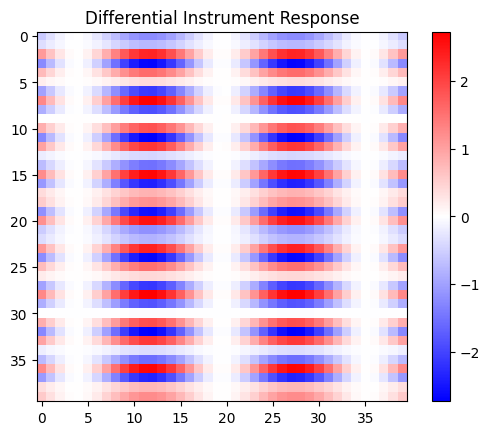

100%|██████████| 1/1 [00:17<00:00, 17.16s/it]


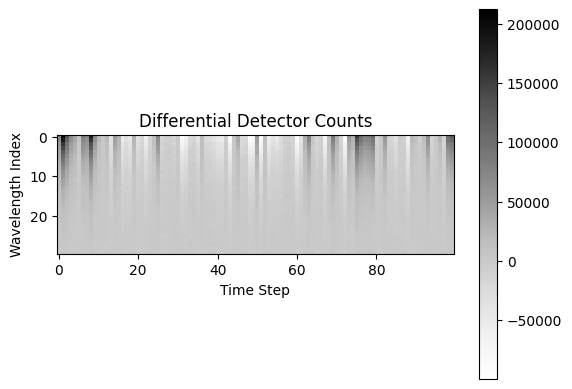

In [13]:
from matplotlib import pyplot as plt

instrument_response = phringe.get_instrument_response_empirical().cpu().numpy()

# Differential instrument response at wavelength index 29 and time step 0
diff_instrument_response = instrument_response[2, 29, 0] - instrument_response[3, 29, 0]

plt.imshow(diff_instrument_response, cmap='bwr')
plt.colorbar()
plt.title('Differential Instrument Response')
plt.show()

# Get and plot the differential detector counts (this may take a a few seconds on CPUs)
counts = phringe.get_diff_counts().cpu().numpy()

plt.imshow(counts[0], cmap='Grays')
plt.colorbar()
plt.title('Differential Detector Counts')
plt.ylabel('Wavelength Index')
plt.xlabel('Time Step')
plt.show()

### Export to NIFITS
Create a file named "data.nifits".

In [ ]:
phringe.export_nifits()